In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

In [43]:
#Data collection
data = yf.download(tickers='JNJ', start='2015-1-1', end='2023-12-31')
data = data['Close']
data

[*********************100%***********************]  1 of 1 completed


Ticker,JNJ
Date,
2015-01-02,104.519997
2015-01-05,103.790001
2015-01-06,103.279999
2015-01-07,105.559998
2015-01-08,106.389999
...,...
2023-12-22,155.460007
2023-12-26,156.139999
2023-12-27,156.350006


In [44]:
# Data collection for future accuracy checking
actual_df = yf.download(tickers='JNJ',start='2023-12-28',end='2024-1-31')
actual_df = actual_df['Close']
actual_df.columns = ['Close']
actual_df

[*********************100%***********************]  1 of 1 completed


,Close
Date,
2023-12-28,156.580002
2023-12-29,156.740005
2024-01-02,159.970001
2024-01-03,160.970001
2024-01-04,160.630005
2024-01-05,161.130005
2024-01-08,161.529999
2024-01-09,161.630005
2024-01-10,161.869995


In [45]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Create sequences
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length, 0])
        y.append(data[i + seq_length, 0])
    return np.array(x), np.array(y)

sequence_length = 50
x, y = create_sequences(data_scaled, sequence_length)

In [46]:
# Reshape input to [samples, time steps, features]
x = np.reshape(x, (x.shape[0], x.shape[1], 1))

In [47]:
# Split into training and testing sets
train_size = int(len(x) * 0.8)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [48]:
# Build the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)),
    LSTM(50, return_sequences=False),
    Dense(25, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\SHREYAS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [49]:
# Training model
model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_test, y_test))

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0418 - val_loss: 0.0018
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 9.1937e-04 - val_loss: 0.0010
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 12/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss:

In [50]:
# Predict using test set
y_pred_scaled = model.predict(x_test)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [51]:
# Inverse transform the scaled data
y_test = scaler.inverse_transform([y_test]).flatten()
y_pred = scaler.inverse_transform(y_pred_scaled).flatten()

#y_test
#y_pred

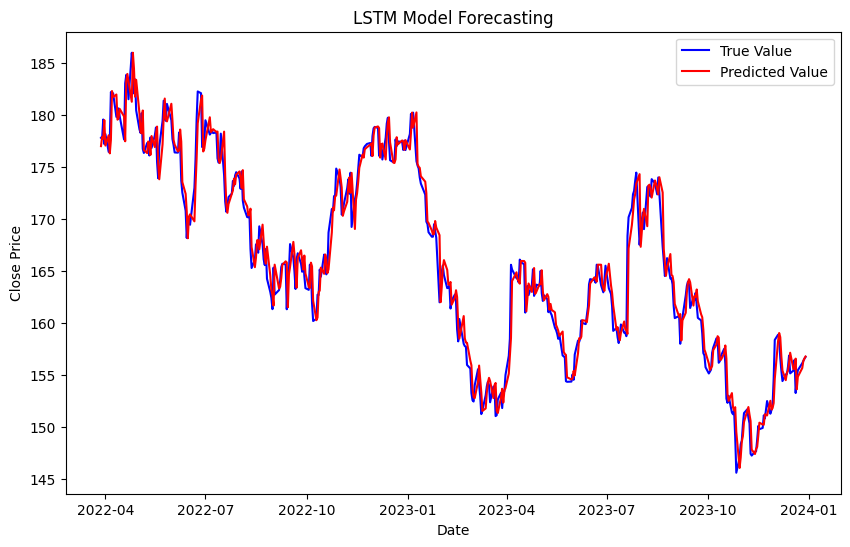

In [52]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(data.index[-len(y_test):], y_test, label='True Value', color='blue')
plt.plot(data.index[-len(y_test):], y_pred, label='Predicted Value', color='red')
plt.legend()
plt.title('LSTM Model Forecasting')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

**Prediction Accuracy**

In [53]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mean_actual = np.mean(y_test)

# Accuracy Calculation
accuracy = 100 - (rmse / mean_actual * 100)

print(f"RMSE: {rmse:.2f}")
print(f"Accuracy: {accuracy:.2f}%")

RMSE: 1.78
Accuracy: 98.93%


**Forecasting**

In [54]:
# Forecast future steps
def forecast_future(model, recent_data, n_steps):
    predictions = []
    current_input = recent_data.copy()

    for _ in range(n_steps):
        prediction = model.predict(current_input[np.newaxis, :, np.newaxis])
        predictions.append(prediction[0, 0])
        current_input = np.roll(current_input, -1)
        current_input[-1] = prediction

    return np.array(predictions)

# Forecast next 30 days
recent_data = data_scaled[-sequence_length:].flatten()
future_steps = 22
future_forecast_scaled = forecast_future(model, recent_data, future_steps)
future_forecast = scaler.inverse_transform(future_forecast_scaled.reshape(-1, 1)).flatten()

print("Future Forecast (Next 30 Days):", future_forecast)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


C:\Users\SHREYAS\AppData\Local\Temp\ipykernel_15092\1723330635.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_input[-1] = prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Future Forecast (Next 30 Days): [156.92587 157.105   157.29112 157.48952 157.69995 157.91924 158.14317
 158.36787 158.59035 158.80885 159.02263 159.23167 159.43648 159.63766
 159.83589 160.03168 160.22537 160.41719 160.60727 160.79565 160.98238
 161.16747]


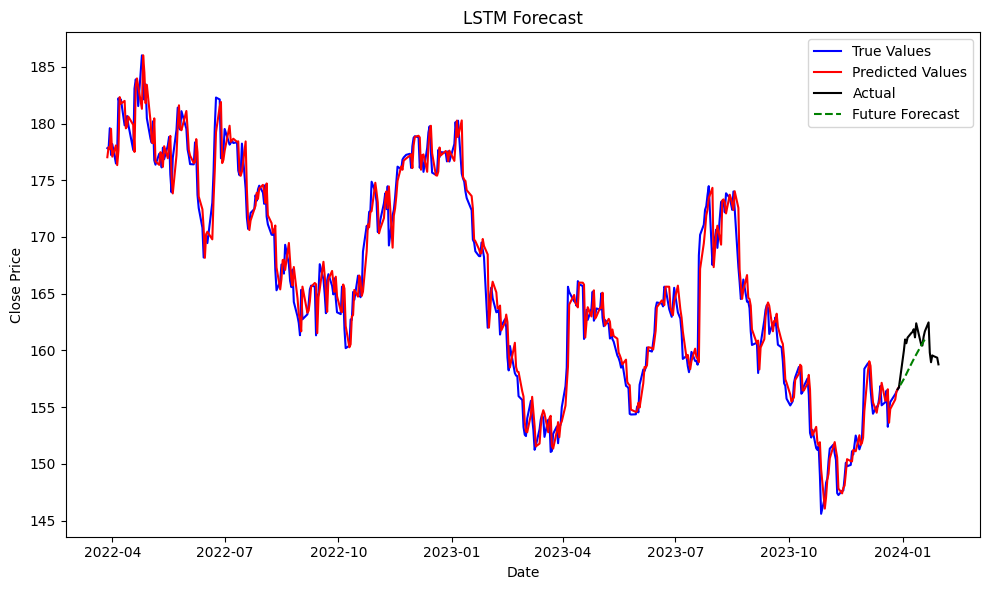

In [55]:
plt.figure(figsize=(10, 6))

# Plot historical true values
plt.plot(data.index[-len(y_test):], y_test, label="True Values", color='blue')

# Plot historical predictions
plt.plot(data.index[-len(y_test):], y_pred, label="Predicted Values", color='red')

# Plot actual values
plt.plot(actual_df['Close'],label='Actual',color='Black')

# Plot future forecast
future_dates = [data.index[-1] + pd.Timedelta(days=i) for i in range(1, future_steps + 1)]
plt.plot(future_dates, future_forecast, label="Future Forecast", color='green', linestyle='--')

# Show plot
plt.title("LSTM Forecast")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.show()

**Prediction**

In [56]:
future_actual_prices = actual_df['Close'].values 

In [57]:
# Calculate Mean Absolute Percentage Error (MAPE)
mape_forecast = np.mean(np.abs((future_actual_prices - future_forecast) / future_actual_prices)) * 100

# Calculate accuracy
accuracy_forecast = 100 - mape_forecast

# Print results
print(f"Forecasting Accuracy: {accuracy_forecast:.2f}%")
print(f"MAPE for Forecasting: {mape_forecast:.2f}%")


Forecasting Accuracy: 98.73%
MAPE for Forecasting: 1.27%
